In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter
import datetime
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 1 to use

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [9]:
EPOCHS = 100
BATCH_SIZE = 32

### Data pre-processing 

In [10]:
# Transformer code
transformer = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

data = glob.glob('/home/NAS_mount2/jwkim/lfw/all_imgs/*.jpg')

# train_test_split
trainpath, testpath = train_test_split(data, test_size=0.2, shuffle=False, random_state=11)


# Customize dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)

        return image


train_dataset = CustomDataset(trainpath, transform=transformer)
test_dataset = CustomDataset(testpath, transform=transformer)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

<class 'torch.Tensor'>
torch.Size([3, 68, 530])


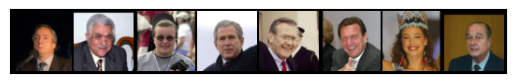

In [21]:
# sample check
sample = next(iter(trainloader))

# show grid image
def imshow_grid(img):
    img = torchvision.utils.make_grid(img)
    print(type(img))
    print(img.shape)
    plt.imshow(img.permute(1, 2, 0))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()


imshow_grid(sample[0:8])



### VAE model architecture

In [22]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size, hidden_size_1, hidden_size_2, latent_size):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(image_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc31 = nn.Linear(hidden_size_2, latent_size)
        self.fc32 = nn.Linear(hidden_size_2, latent_size)

        self.fc4 = nn.Linear(latent_size, hidden_size_2)
        self.fc5 = nn.Linear(hidden_size_2, hidden_size_1)
        self.fc6 = nn.Linear(hidden_size_1, image_size)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc31(h2), self.fc32(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        h3 = F.relu(self.fc4(z))
        h4 = F.relu(self.fc5(h3))
        return torch.sigmoid(self.fc6(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 4096))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


### Modeling 

In [23]:
latent_size = 2

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
VAE_model = VAE(64*64, 512, 256, latent_size).to(DEVICE)

# Optimizer
optimizer = optim.Adam(VAE_model.parameters(), lr = 1e-3)
     
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 4096), reduction = 'sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD

In [24]:
def train(epoch, model, train_loader, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data) in enumerate(train_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)

        BCE, KLD = loss_function(recon_batch, data, mu, logvar)

        loss = BCE + KLD

        # writer.add_scalar("Train/Reconstruction Error", BCE.item() / len(data), batch_idx + epoch * (len(train_loader.dataset)/BATCH_SIZE) )
        # writer.add_scalar("Train/KL-Divergence", KLD.item() / len(data), batch_idx + epoch * (len(train_loader.dataset)/BATCH_SIZE) )
        # writer.add_scalar("Train/Total Loss" , loss.item() / len(data), batch_idx + epoch * (len(train_loader.dataset)/BATCH_SIZE) )

        loss.backward()

        train_loss += loss.item()

        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
            
    print("======> Epoch: {} Average loss: {:.4f}".format(
        epoch, train_loss / len(train_loader.dataset)
    ))        

In [25]:
def test(model, image_path):
    model.eval()
    with torch.no_grad():
        transformer = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])
        
        input_image = Image.open(image_path)
        input_image = transformer(input_image).unsqueeze(0).to(DEVICE)
        
        reconstructed_image, _, _ = model(input_image)
        input_image = input_image.squeeze(0).cpu().numpy()
        reconstructed_image = reconstructed_image.squeeze(0).cpu().numpy()
        reconstructed_image = reconstructed_image.reshape(3, 64, 64)  # image shape 
        
        plt.figure(figsize=(4,2))
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(input_image.transpose(1, 2, 0))  # change to (hegit, width, channel)

        plt.subplot(1, 2, 2)
        plt.title('Reconstructed Image')
        plt.imshow(reconstructed_image.transpose(1, 2, 0))

        plt.show()
        

In [26]:
def latent_to_image(epoch, model):
    with torch.no_grad():
        sample = torch.randn(64, latent_size).to(DEVICE)
        recon_image = model.decode(sample).cpu()
        grid = torchvision.utils.make_grid(recon_image.view(64, 1, 64, 64))
        # writer.add_image("Latent To Image", grid, epoch)


### Train

In [32]:
for epoch in tqdm(range(0, EPOCHS)):
    train(epoch, VAE_model, trainloader, optimizer)
    print("\n")
    latent_to_image(epoch, VAE_model)

  0%|          | 0/70 [00:00<?, ?it/s]

Train Epoch: 0 [0/10586 (0%)]	 Loss: 7392.824219
Train Epoch: 0 [3200/10586 (30%)]	 Loss: 7462.298340
Train Epoch: 0 [6400/10586 (60%)]	 Loss: 7289.986816
Train Epoch: 0 [9600/10586 (91%)]	 Loss: 7056.575684


  1%|▏         | 1/70 [03:03<3:31:11, 183.64s/it]

======> Epoch: 0 Average loss: 7321.2929


Train Epoch: 1 [0/10586 (0%)]	 Loss: 7570.829102
Train Epoch: 1 [3200/10586 (30%)]	 Loss: 7173.576660
Train Epoch: 1 [6400/10586 (60%)]	 Loss: 7438.729980
Train Epoch: 1 [9600/10586 (91%)]	 Loss: 7539.440918


  3%|▎         | 2/70 [06:09<3:29:29, 184.85s/it]

======> Epoch: 1 Average loss: 7316.7566


Train Epoch: 2 [0/10586 (0%)]	 Loss: 6963.194336
Train Epoch: 2 [3200/10586 (30%)]	 Loss: 7382.230957
Train Epoch: 2 [6400/10586 (60%)]	 Loss: 7420.010742
Train Epoch: 2 [9600/10586 (91%)]	 Loss: 7659.947266


  4%|▍         | 3/70 [09:15<3:27:08, 185.50s/it]

======> Epoch: 2 Average loss: 7316.3150


Train Epoch: 3 [0/10586 (0%)]	 Loss: 7396.457031
Train Epoch: 3 [3200/10586 (30%)]	 Loss: 7493.617676
Train Epoch: 3 [6400/10586 (60%)]	 Loss: 7068.381348
Train Epoch: 3 [9600/10586 (91%)]	 Loss: 7198.913574


  6%|▌         | 4/70 [12:20<3:23:36, 185.09s/it]

======> Epoch: 3 Average loss: 7313.2787


Train Epoch: 4 [0/10586 (0%)]	 Loss: 7584.832031
Train Epoch: 4 [3200/10586 (30%)]	 Loss: 7281.064941
Train Epoch: 4 [6400/10586 (60%)]	 Loss: 7412.124023
Train Epoch: 4 [9600/10586 (91%)]	 Loss: 7341.625977


  7%|▋         | 5/70 [15:24<3:20:12, 184.81s/it]

======> Epoch: 4 Average loss: 7304.9104


Train Epoch: 5 [0/10586 (0%)]	 Loss: 7404.729004
Train Epoch: 5 [3200/10586 (30%)]	 Loss: 7610.973633
Train Epoch: 5 [6400/10586 (60%)]	 Loss: 7249.409668
Train Epoch: 5 [9600/10586 (91%)]	 Loss: 7438.986328


  9%|▊         | 6/70 [18:34<3:18:55, 186.50s/it]

======> Epoch: 5 Average loss: 7301.9019


Train Epoch: 6 [0/10586 (0%)]	 Loss: 7214.712402
Train Epoch: 6 [3200/10586 (30%)]	 Loss: 6805.798340
Train Epoch: 6 [6400/10586 (60%)]	 Loss: 7287.526367
Train Epoch: 6 [9600/10586 (91%)]	 Loss: 7280.536621


 10%|█         | 7/70 [21:44<3:16:58, 187.59s/it]

======> Epoch: 6 Average loss: 7303.0814


Train Epoch: 7 [0/10586 (0%)]	 Loss: 7182.858398
Train Epoch: 7 [3200/10586 (30%)]	 Loss: 7239.363281
Train Epoch: 7 [6400/10586 (60%)]	 Loss: 6946.867188
Train Epoch: 7 [9600/10586 (91%)]	 Loss: 7383.865234


 11%|█▏        | 8/70 [24:51<3:13:39, 187.41s/it]

======> Epoch: 7 Average loss: 7316.7028


Train Epoch: 8 [0/10586 (0%)]	 Loss: 7100.512207
Train Epoch: 8 [3200/10586 (30%)]	 Loss: 7284.674316
Train Epoch: 8 [6400/10586 (60%)]	 Loss: 7558.577637
Train Epoch: 8 [9600/10586 (91%)]	 Loss: 7394.943359


 13%|█▎        | 9/70 [28:02<3:11:53, 188.75s/it]

======> Epoch: 8 Average loss: 7289.2137


Train Epoch: 9 [0/10586 (0%)]	 Loss: 7400.101074
Train Epoch: 9 [3200/10586 (30%)]	 Loss: 7303.937500
Train Epoch: 9 [6400/10586 (60%)]	 Loss: 7362.876465
Train Epoch: 9 [9600/10586 (91%)]	 Loss: 7438.473145


 14%|█▍        | 10/70 [31:12<3:09:12, 189.20s/it]

======> Epoch: 9 Average loss: 7290.7272


Train Epoch: 10 [0/10586 (0%)]	 Loss: 7259.820801
Train Epoch: 10 [3200/10586 (30%)]	 Loss: 7102.186523
Train Epoch: 10 [6400/10586 (60%)]	 Loss: 7127.974121
Train Epoch: 10 [9600/10586 (91%)]	 Loss: 7414.847168


 16%|█▌        | 11/70 [34:15<3:04:01, 187.14s/it]

======> Epoch: 10 Average loss: 7288.5774


Train Epoch: 11 [0/10586 (0%)]	 Loss: 7349.522461
Train Epoch: 11 [3200/10586 (30%)]	 Loss: 7507.398926
Train Epoch: 11 [6400/10586 (60%)]	 Loss: 7435.391602
Train Epoch: 11 [9600/10586 (91%)]	 Loss: 7257.188965


 17%|█▋        | 12/70 [37:18<2:59:37, 185.82s/it]

======> Epoch: 11 Average loss: 7299.4923


Train Epoch: 12 [0/10586 (0%)]	 Loss: 7231.007812
Train Epoch: 12 [3200/10586 (30%)]	 Loss: 7258.489746
Train Epoch: 12 [6400/10586 (60%)]	 Loss: 7134.437012
Train Epoch: 12 [9600/10586 (91%)]	 Loss: 6966.046387


 19%|█▊        | 13/70 [40:26<2:57:05, 186.42s/it]

======> Epoch: 12 Average loss: 7286.4207


Train Epoch: 13 [0/10586 (0%)]	 Loss: 7298.136230
Train Epoch: 13 [3200/10586 (30%)]	 Loss: 7499.123047
Train Epoch: 13 [6400/10586 (60%)]	 Loss: 7171.731445
Train Epoch: 13 [9600/10586 (91%)]	 Loss: 7271.497559


 20%|██        | 14/70 [43:39<2:55:51, 188.42s/it]

======> Epoch: 13 Average loss: 7299.1286


Train Epoch: 14 [0/10586 (0%)]	 Loss: 7526.441406
Train Epoch: 14 [3200/10586 (30%)]	 Loss: 7089.229980
Train Epoch: 14 [6400/10586 (60%)]	 Loss: 6998.686523
Train Epoch: 14 [9600/10586 (91%)]	 Loss: 7316.925781


 21%|██▏       | 15/70 [47:03<2:57:13, 193.34s/it]

======> Epoch: 14 Average loss: 7286.4391


Train Epoch: 15 [0/10586 (0%)]	 Loss: 7202.216797
Train Epoch: 15 [3200/10586 (30%)]	 Loss: 7644.260742
Train Epoch: 15 [6400/10586 (60%)]	 Loss: 7257.455566
Train Epoch: 15 [9600/10586 (91%)]	 Loss: 7388.532227


 23%|██▎       | 16/70 [50:28<2:57:03, 196.73s/it]

======> Epoch: 15 Average loss: 7293.4963


Train Epoch: 16 [0/10586 (0%)]	 Loss: 7150.575195
Train Epoch: 16 [3200/10586 (30%)]	 Loss: 7369.889648
Train Epoch: 16 [6400/10586 (60%)]	 Loss: 7075.887207
Train Epoch: 16 [9600/10586 (91%)]	 Loss: 7382.249023


 24%|██▍       | 17/70 [53:52<2:55:38, 198.84s/it]

======> Epoch: 16 Average loss: 7282.4630


Train Epoch: 17 [0/10586 (0%)]	 Loss: 7316.410156
Train Epoch: 17 [3200/10586 (30%)]	 Loss: 7231.421875
Train Epoch: 17 [6400/10586 (60%)]	 Loss: 7230.384766
Train Epoch: 17 [9600/10586 (91%)]	 Loss: 7257.155762


 26%|██▌       | 18/70 [57:09<2:51:53, 198.34s/it]

======> Epoch: 17 Average loss: 7280.8397


Train Epoch: 18 [0/10586 (0%)]	 Loss: 7402.989746
Train Epoch: 18 [3200/10586 (30%)]	 Loss: 6985.779785
Train Epoch: 18 [6400/10586 (60%)]	 Loss: 7235.432617
Train Epoch: 18 [9600/10586 (91%)]	 Loss: 7509.437012


 27%|██▋       | 19/70 [1:00:32<2:49:45, 199.72s/it]

======> Epoch: 18 Average loss: 7289.1718


Train Epoch: 19 [0/10586 (0%)]	 Loss: 7289.303711
Train Epoch: 19 [3200/10586 (30%)]	 Loss: 7115.525879
Train Epoch: 19 [6400/10586 (60%)]	 Loss: 7175.816406
Train Epoch: 19 [9600/10586 (91%)]	 Loss: 7365.566406


 29%|██▊       | 20/70 [1:03:48<2:45:40, 198.81s/it]

======> Epoch: 19 Average loss: 7283.5302


Train Epoch: 20 [0/10586 (0%)]	 Loss: 7146.727051
Train Epoch: 20 [3200/10586 (30%)]	 Loss: 7281.104980
Train Epoch: 20 [6400/10586 (60%)]	 Loss: 7378.786133
Train Epoch: 20 [9600/10586 (91%)]	 Loss: 7619.651855


 30%|███       | 21/70 [1:07:08<2:42:25, 198.89s/it]

======> Epoch: 20 Average loss: 7280.9053


Train Epoch: 21 [0/10586 (0%)]	 Loss: 7558.199707
Train Epoch: 21 [3200/10586 (30%)]	 Loss: 7202.769531
Train Epoch: 21 [6400/10586 (60%)]	 Loss: 7331.323730
Train Epoch: 21 [9600/10586 (91%)]	 Loss: 7477.779297


 31%|███▏      | 22/70 [1:10:19<2:37:26, 196.79s/it]

======> Epoch: 21 Average loss: 7279.8201


Train Epoch: 22 [0/10586 (0%)]	 Loss: 7571.355957
Train Epoch: 22 [3200/10586 (30%)]	 Loss: 7314.459473
Train Epoch: 22 [6400/10586 (60%)]	 Loss: 7137.414551
Train Epoch: 22 [9600/10586 (91%)]	 Loss: 7216.567383


 33%|███▎      | 23/70 [1:13:36<2:34:01, 196.63s/it]

======> Epoch: 22 Average loss: 7272.7782


Train Epoch: 23 [0/10586 (0%)]	 Loss: 7510.783691
Train Epoch: 23 [3200/10586 (30%)]	 Loss: 7289.797363
Train Epoch: 23 [6400/10586 (60%)]	 Loss: 7489.399902
Train Epoch: 23 [9600/10586 (91%)]	 Loss: 7055.738281


 34%|███▍      | 24/70 [1:17:04<2:33:24, 200.10s/it]

======> Epoch: 23 Average loss: 7287.2333


Train Epoch: 24 [0/10586 (0%)]	 Loss: 7253.997559
Train Epoch: 24 [3200/10586 (30%)]	 Loss: 7442.925293
Train Epoch: 24 [6400/10586 (60%)]	 Loss: 7665.555176
Train Epoch: 24 [9600/10586 (91%)]	 Loss: 7361.726074


 36%|███▌      | 25/70 [1:20:58<2:37:46, 210.38s/it]

======> Epoch: 24 Average loss: 7296.4085


Train Epoch: 25 [0/10586 (0%)]	 Loss: 7441.836426
Train Epoch: 25 [3200/10586 (30%)]	 Loss: 7200.959473
Train Epoch: 25 [6400/10586 (60%)]	 Loss: 7189.779785
Train Epoch: 25 [9600/10586 (91%)]	 Loss: 7417.545410


 37%|███▋      | 26/70 [1:24:41<2:36:55, 214.00s/it]

======> Epoch: 25 Average loss: 7278.6946


Train Epoch: 26 [0/10586 (0%)]	 Loss: 7247.240234
Train Epoch: 26 [3200/10586 (30%)]	 Loss: 6959.500488
Train Epoch: 26 [6400/10586 (60%)]	 Loss: 7304.062012
Train Epoch: 26 [9600/10586 (91%)]	 Loss: 7250.805664


 39%|███▊      | 27/70 [1:28:04<2:31:06, 210.84s/it]

======> Epoch: 26 Average loss: 7296.2230


Train Epoch: 27 [0/10586 (0%)]	 Loss: 7342.540527
Train Epoch: 27 [3200/10586 (30%)]	 Loss: 7281.352051
Train Epoch: 27 [6400/10586 (60%)]	 Loss: 7265.764160
Train Epoch: 27 [9600/10586 (91%)]	 Loss: 7183.140137


 40%|████      | 28/70 [1:31:25<2:25:23, 207.71s/it]

======> Epoch: 27 Average loss: 7283.3563


Train Epoch: 28 [0/10586 (0%)]	 Loss: 7141.641602
Train Epoch: 28 [3200/10586 (30%)]	 Loss: 7108.023926
Train Epoch: 28 [6400/10586 (60%)]	 Loss: 7375.457520
Train Epoch: 28 [9600/10586 (91%)]	 Loss: 7341.712891


 41%|████▏     | 29/70 [1:34:45<2:20:25, 205.49s/it]

======> Epoch: 28 Average loss: 7277.0068


Train Epoch: 29 [0/10586 (0%)]	 Loss: 6765.991211
Train Epoch: 29 [3200/10586 (30%)]	 Loss: 7056.864746
Train Epoch: 29 [6400/10586 (60%)]	 Loss: 7315.162598
Train Epoch: 29 [9600/10586 (91%)]	 Loss: 7493.064453


 43%|████▎     | 30/70 [1:38:01<2:15:09, 202.74s/it]

======> Epoch: 29 Average loss: 7271.9830


Train Epoch: 30 [0/10586 (0%)]	 Loss: 7488.296387
Train Epoch: 30 [3200/10586 (30%)]	 Loss: 7176.762695
Train Epoch: 30 [6400/10586 (60%)]	 Loss: 7131.112793
Train Epoch: 30 [9600/10586 (91%)]	 Loss: 7030.997070


 44%|████▍     | 31/70 [1:41:27<2:12:25, 203.72s/it]

======> Epoch: 30 Average loss: 7270.1826


Train Epoch: 31 [0/10586 (0%)]	 Loss: 7282.638184
Train Epoch: 31 [3200/10586 (30%)]	 Loss: 7485.621094
Train Epoch: 31 [6400/10586 (60%)]	 Loss: 7344.056641
Train Epoch: 31 [9600/10586 (91%)]	 Loss: 7476.966797


 46%|████▌     | 32/70 [1:45:56<2:21:22, 223.22s/it]

======> Epoch: 31 Average loss: 7323.3426


Train Epoch: 32 [0/10586 (0%)]	 Loss: 7610.643555
Train Epoch: 32 [3200/10586 (30%)]	 Loss: 7176.121094
Train Epoch: 32 [6400/10586 (60%)]	 Loss: 7542.690918
Train Epoch: 32 [9600/10586 (91%)]	 Loss: 7314.291504


 47%|████▋     | 33/70 [1:50:32<2:27:21, 238.96s/it]

======> Epoch: 32 Average loss: 7297.3661


Train Epoch: 33 [0/10586 (0%)]	 Loss: 7272.105957
Train Epoch: 33 [3200/10586 (30%)]	 Loss: 7322.245117
Train Epoch: 33 [6400/10586 (60%)]	 Loss: 7384.861816
Train Epoch: 33 [9600/10586 (91%)]	 Loss: 7082.468262


 49%|████▊     | 34/70 [1:54:51<2:26:58, 244.97s/it]

======> Epoch: 33 Average loss: 7287.7057


Train Epoch: 34 [0/10586 (0%)]	 Loss: 7435.234375
Train Epoch: 34 [3200/10586 (30%)]	 Loss: 7312.096680
Train Epoch: 34 [6400/10586 (60%)]	 Loss: 7253.665527
Train Epoch: 34 [9600/10586 (91%)]	 Loss: 7045.832520


 50%|█████     | 35/70 [1:58:20<2:16:36, 234.18s/it]

======> Epoch: 34 Average loss: 7283.2622


Train Epoch: 35 [0/10586 (0%)]	 Loss: 7296.460449
Train Epoch: 35 [3200/10586 (30%)]	 Loss: 7430.641602
Train Epoch: 35 [6400/10586 (60%)]	 Loss: 7412.136230
Train Epoch: 35 [9600/10586 (91%)]	 Loss: 7344.848633


 51%|█████▏    | 36/70 [2:01:40<2:06:53, 223.93s/it]

======> Epoch: 35 Average loss: 7286.0512


Train Epoch: 36 [0/10586 (0%)]	 Loss: 7251.478516
Train Epoch: 36 [3200/10586 (30%)]	 Loss: 7243.604004
Train Epoch: 36 [6400/10586 (60%)]	 Loss: 7204.202148
Train Epoch: 36 [9600/10586 (91%)]	 Loss: 7670.690430


 53%|█████▎    | 37/70 [2:04:58<1:58:58, 216.31s/it]

======> Epoch: 36 Average loss: 7285.4586


Train Epoch: 37 [0/10586 (0%)]	 Loss: 7228.224121
Train Epoch: 37 [3200/10586 (30%)]	 Loss: 6979.676270
Train Epoch: 37 [6400/10586 (60%)]	 Loss: 7146.529785
Train Epoch: 37 [9600/10586 (91%)]	 Loss: 7122.776367


 54%|█████▍    | 38/70 [2:08:04<1:50:32, 207.26s/it]

======> Epoch: 37 Average loss: 7276.7581


Train Epoch: 38 [0/10586 (0%)]	 Loss: 7435.402344
Train Epoch: 38 [3200/10586 (30%)]	 Loss: 7104.242188
Train Epoch: 38 [6400/10586 (60%)]	 Loss: 7542.085449
Train Epoch: 38 [9600/10586 (91%)]	 Loss: 7485.276855


 56%|█████▌    | 39/70 [2:11:17<1:44:48, 202.86s/it]

======> Epoch: 38 Average loss: 7276.1710


Train Epoch: 39 [0/10586 (0%)]	 Loss: 7156.650879
Train Epoch: 39 [3200/10586 (30%)]	 Loss: 7147.279785
Train Epoch: 39 [6400/10586 (60%)]	 Loss: 7367.501953
Train Epoch: 39 [9600/10586 (91%)]	 Loss: 7441.992188


 57%|█████▋    | 40/70 [2:14:25<1:39:09, 198.31s/it]

======> Epoch: 39 Average loss: 7277.6630


Train Epoch: 40 [0/10586 (0%)]	 Loss: 7238.202637
Train Epoch: 40 [3200/10586 (30%)]	 Loss: 7239.556641
Train Epoch: 40 [6400/10586 (60%)]	 Loss: 7590.749512
Train Epoch: 40 [9600/10586 (91%)]	 Loss: 7447.724609


 59%|█████▊    | 41/70 [2:17:38<1:35:09, 196.88s/it]

======> Epoch: 40 Average loss: 7298.0842


Train Epoch: 41 [0/10586 (0%)]	 Loss: 7475.310547
Train Epoch: 41 [3200/10586 (30%)]	 Loss: 7393.978516
Train Epoch: 41 [6400/10586 (60%)]	 Loss: 7291.442383
Train Epoch: 41 [9600/10586 (91%)]	 Loss: 7375.341309


 60%|██████    | 42/70 [2:20:45<1:30:29, 193.90s/it]

======> Epoch: 41 Average loss: 7280.8175


Train Epoch: 42 [0/10586 (0%)]	 Loss: 7343.063965
Train Epoch: 42 [3200/10586 (30%)]	 Loss: 7463.398438
Train Epoch: 42 [6400/10586 (60%)]	 Loss: 7258.219238
Train Epoch: 42 [9600/10586 (91%)]	 Loss: 7397.665039


 61%|██████▏   | 43/70 [2:23:49<1:25:53, 190.88s/it]

======> Epoch: 42 Average loss: 7287.5862


Train Epoch: 43 [0/10586 (0%)]	 Loss: 7468.837402
Train Epoch: 43 [3200/10586 (30%)]	 Loss: 7357.171387
Train Epoch: 43 [6400/10586 (60%)]	 Loss: 7030.049805
Train Epoch: 43 [9600/10586 (91%)]	 Loss: 7282.678223


 63%|██████▎   | 44/70 [2:26:54<1:21:57, 189.15s/it]

======> Epoch: 43 Average loss: 7279.4089


Train Epoch: 44 [0/10586 (0%)]	 Loss: 7315.017090
Train Epoch: 44 [3200/10586 (30%)]	 Loss: 7520.503906
Train Epoch: 44 [6400/10586 (60%)]	 Loss: 7468.430176
Train Epoch: 44 [9600/10586 (91%)]	 Loss: 7425.902832


 64%|██████▍   | 45/70 [2:30:01<1:18:32, 188.49s/it]

======> Epoch: 44 Average loss: 7272.8778


Train Epoch: 45 [0/10586 (0%)]	 Loss: 7151.168457
Train Epoch: 45 [3200/10586 (30%)]	 Loss: 7381.532715
Train Epoch: 45 [6400/10586 (60%)]	 Loss: 7248.996094
Train Epoch: 45 [9600/10586 (91%)]	 Loss: 7137.970703


 66%|██████▌   | 46/70 [2:33:07<1:15:04, 187.69s/it]

======> Epoch: 45 Average loss: 7282.2913


Train Epoch: 46 [0/10586 (0%)]	 Loss: 7295.461914
Train Epoch: 46 [3200/10586 (30%)]	 Loss: 6911.748047
Train Epoch: 46 [6400/10586 (60%)]	 Loss: 7242.147461
Train Epoch: 46 [9600/10586 (91%)]	 Loss: 7548.253418


 67%|██████▋   | 47/70 [2:36:12<1:11:42, 187.08s/it]

======> Epoch: 46 Average loss: 7271.9471


Train Epoch: 47 [0/10586 (0%)]	 Loss: 7320.652832
Train Epoch: 47 [3200/10586 (30%)]	 Loss: 7417.197754
Train Epoch: 47 [6400/10586 (60%)]	 Loss: 7287.640625
Train Epoch: 47 [9600/10586 (91%)]	 Loss: 7605.346680


 69%|██████▊   | 48/70 [2:39:21<1:08:42, 187.39s/it]

======> Epoch: 47 Average loss: 7266.3547


Train Epoch: 48 [0/10586 (0%)]	 Loss: 7396.350098
Train Epoch: 48 [3200/10586 (30%)]	 Loss: 7178.309082
Train Epoch: 48 [6400/10586 (60%)]	 Loss: 7287.074219
Train Epoch: 48 [9600/10586 (91%)]	 Loss: 7398.052246


 70%|███████   | 49/70 [2:42:29<1:05:41, 187.71s/it]

======> Epoch: 48 Average loss: 7280.4530


Train Epoch: 49 [0/10586 (0%)]	 Loss: 7193.169434
Train Epoch: 49 [3200/10586 (30%)]	 Loss: 7271.220215
Train Epoch: 49 [6400/10586 (60%)]	 Loss: 7367.601562
Train Epoch: 49 [9600/10586 (91%)]	 Loss: 7352.203125


 71%|███████▏  | 50/70 [2:45:38<1:02:43, 188.15s/it]

======> Epoch: 49 Average loss: 7309.3040


Train Epoch: 50 [0/10586 (0%)]	 Loss: 7304.332031
Train Epoch: 50 [3200/10586 (30%)]	 Loss: 7379.270020
Train Epoch: 50 [6400/10586 (60%)]	 Loss: 7255.895996
Train Epoch: 50 [9600/10586 (91%)]	 Loss: 7162.404297


 73%|███████▎  | 51/70 [2:48:44<59:22, 187.48s/it]  

======> Epoch: 50 Average loss: 7308.2782


Train Epoch: 51 [0/10586 (0%)]	 Loss: 7210.770020
Train Epoch: 51 [3200/10586 (30%)]	 Loss: 7328.944336
Train Epoch: 51 [6400/10586 (60%)]	 Loss: 7090.442383
Train Epoch: 51 [9600/10586 (91%)]	 Loss: 7181.639160


 74%|███████▍  | 52/70 [2:51:55<56:30, 188.38s/it]

======> Epoch: 51 Average loss: 7285.5115


Train Epoch: 52 [0/10586 (0%)]	 Loss: 7403.906250
Train Epoch: 52 [3200/10586 (30%)]	 Loss: 7312.305664
Train Epoch: 52 [6400/10586 (60%)]	 Loss: 7333.778320
Train Epoch: 52 [9600/10586 (91%)]	 Loss: 7294.408203


 76%|███████▌  | 53/70 [2:55:11<54:03, 190.82s/it]

======> Epoch: 52 Average loss: 7293.3671


Train Epoch: 53 [0/10586 (0%)]	 Loss: 7366.299805
Train Epoch: 53 [3200/10586 (30%)]	 Loss: 7036.341309
Train Epoch: 53 [6400/10586 (60%)]	 Loss: 7201.649414
Train Epoch: 53 [9600/10586 (91%)]	 Loss: 7048.379883


 77%|███████▋  | 54/70 [2:58:29<51:28, 193.06s/it]

======> Epoch: 53 Average loss: 7299.2554


Train Epoch: 54 [0/10586 (0%)]	 Loss: 7107.640625
Train Epoch: 54 [3200/10586 (30%)]	 Loss: 7339.361816
Train Epoch: 54 [6400/10586 (60%)]	 Loss: 7458.229004
Train Epoch: 54 [9600/10586 (91%)]	 Loss: 7262.007812


 79%|███████▊  | 55/70 [3:01:41<48:11, 192.77s/it]

======> Epoch: 54 Average loss: 7289.6593


Train Epoch: 55 [0/10586 (0%)]	 Loss: 7452.081055
Train Epoch: 55 [3200/10586 (30%)]	 Loss: 7194.127930
Train Epoch: 55 [6400/10586 (60%)]	 Loss: 7124.274902
Train Epoch: 55 [9600/10586 (91%)]	 Loss: 6943.383789


 80%|████████  | 56/70 [3:04:50<44:41, 191.54s/it]

======> Epoch: 55 Average loss: 7274.6616


Train Epoch: 56 [0/10586 (0%)]	 Loss: 7511.178711
Train Epoch: 56 [3200/10586 (30%)]	 Loss: 7163.558594
Train Epoch: 56 [6400/10586 (60%)]	 Loss: 7203.679199
Train Epoch: 56 [9600/10586 (91%)]	 Loss: 6917.516113


 81%|████████▏ | 57/70 [3:08:00<41:22, 190.93s/it]

======> Epoch: 56 Average loss: 7270.9949


Train Epoch: 57 [0/10586 (0%)]	 Loss: 7012.435059
Train Epoch: 57 [3200/10586 (30%)]	 Loss: 7153.869629
Train Epoch: 57 [6400/10586 (60%)]	 Loss: 7334.414551
Train Epoch: 57 [9600/10586 (91%)]	 Loss: 7375.570312


 83%|████████▎ | 58/70 [3:11:14<38:23, 191.96s/it]

======> Epoch: 57 Average loss: 7274.4080


Train Epoch: 58 [0/10586 (0%)]	 Loss: 7379.759766
Train Epoch: 58 [3200/10586 (30%)]	 Loss: 7395.771484
Train Epoch: 58 [6400/10586 (60%)]	 Loss: 7299.369141
Train Epoch: 58 [9600/10586 (91%)]	 Loss: 7095.316406


 84%|████████▍ | 59/70 [3:14:33<35:35, 194.11s/it]

======> Epoch: 58 Average loss: 7273.8596


Train Epoch: 59 [0/10586 (0%)]	 Loss: 7261.297852
Train Epoch: 59 [3200/10586 (30%)]	 Loss: 7575.381348
Train Epoch: 59 [6400/10586 (60%)]	 Loss: 7169.031250
Train Epoch: 59 [9600/10586 (91%)]	 Loss: 7198.544922


 86%|████████▌ | 60/70 [3:17:53<32:38, 195.87s/it]

======> Epoch: 59 Average loss: 7268.7863


Train Epoch: 60 [0/10586 (0%)]	 Loss: 7271.184570
Train Epoch: 60 [3200/10586 (30%)]	 Loss: 7337.642578
Train Epoch: 60 [6400/10586 (60%)]	 Loss: 7486.640137
Train Epoch: 60 [9600/10586 (91%)]	 Loss: 7166.510254


 87%|████████▋ | 61/70 [3:21:12<29:29, 196.64s/it]

======> Epoch: 60 Average loss: 7269.2165


Train Epoch: 61 [0/10586 (0%)]	 Loss: 7224.841797
Train Epoch: 61 [3200/10586 (30%)]	 Loss: 7233.099121
Train Epoch: 61 [6400/10586 (60%)]	 Loss: 7169.294922
Train Epoch: 61 [9600/10586 (91%)]	 Loss: 7327.979980


 89%|████████▊ | 62/70 [3:24:38<26:35, 199.49s/it]

======> Epoch: 61 Average loss: 7272.4641


Train Epoch: 62 [0/10586 (0%)]	 Loss: 7373.552734
Train Epoch: 62 [3200/10586 (30%)]	 Loss: 7622.902832
Train Epoch: 62 [6400/10586 (60%)]	 Loss: 7198.020020
Train Epoch: 62 [9600/10586 (91%)]	 Loss: 7359.677246


 90%|█████████ | 63/70 [3:27:56<23:14, 199.26s/it]

======> Epoch: 62 Average loss: 7267.2858


Train Epoch: 63 [0/10586 (0%)]	 Loss: 7242.287109
Train Epoch: 63 [3200/10586 (30%)]	 Loss: 7141.563477
Train Epoch: 63 [6400/10586 (60%)]	 Loss: 7554.161133
Train Epoch: 63 [9600/10586 (91%)]	 Loss: 7309.764160


 91%|█████████▏| 64/70 [3:31:14<19:51, 198.62s/it]

======> Epoch: 63 Average loss: 7264.3582


Train Epoch: 64 [0/10586 (0%)]	 Loss: 7499.190430
Train Epoch: 64 [3200/10586 (30%)]	 Loss: 7461.004395
Train Epoch: 64 [6400/10586 (60%)]	 Loss: 7265.433594
Train Epoch: 64 [9600/10586 (91%)]	 Loss: 7143.347168


 93%|█████████▎| 65/70 [3:34:35<16:37, 199.58s/it]

======> Epoch: 64 Average loss: 7280.1714


Train Epoch: 65 [0/10586 (0%)]	 Loss: 7490.246094
Train Epoch: 65 [3200/10586 (30%)]	 Loss: 7144.399902
Train Epoch: 65 [6400/10586 (60%)]	 Loss: 7079.185059
Train Epoch: 65 [9600/10586 (91%)]	 Loss: 7241.958496


 94%|█████████▍| 66/70 [3:37:55<13:18, 199.50s/it]

======> Epoch: 65 Average loss: 7294.1164


Train Epoch: 66 [0/10586 (0%)]	 Loss: 7302.846191
Train Epoch: 66 [3200/10586 (30%)]	 Loss: 7354.714355
Train Epoch: 66 [6400/10586 (60%)]	 Loss: 7363.550293
Train Epoch: 66 [9600/10586 (91%)]	 Loss: 7390.998047


 96%|█████████▌| 67/70 [3:41:08<09:53, 197.71s/it]

======> Epoch: 66 Average loss: 7284.6165


Train Epoch: 67 [0/10586 (0%)]	 Loss: 7551.917969
Train Epoch: 67 [3200/10586 (30%)]	 Loss: 7012.979980
Train Epoch: 67 [6400/10586 (60%)]	 Loss: 7202.322266
Train Epoch: 67 [9600/10586 (91%)]	 Loss: 7252.030762


 97%|█████████▋| 68/70 [3:44:20<06:32, 196.03s/it]

======> Epoch: 67 Average loss: 7269.2693


Train Epoch: 68 [0/10586 (0%)]	 Loss: 7403.355957
Train Epoch: 68 [3200/10586 (30%)]	 Loss: 7216.298340
Train Epoch: 68 [6400/10586 (60%)]	 Loss: 7187.065430
Train Epoch: 68 [9600/10586 (91%)]	 Loss: 7128.768066


 99%|█████████▊| 69/70 [3:47:33<03:15, 195.00s/it]

======> Epoch: 68 Average loss: 7270.8926


Train Epoch: 69 [0/10586 (0%)]	 Loss: 7123.948730
Train Epoch: 69 [3200/10586 (30%)]	 Loss: 7494.188477
Train Epoch: 69 [6400/10586 (60%)]	 Loss: 7286.357910
Train Epoch: 69 [9600/10586 (91%)]	 Loss: 7397.292969


100%|██████████| 70/70 [3:50:44<00:00, 197.78s/it]

======> Epoch: 69 Average loss: 7260.6630




In [33]:
# save model
model_save_path = 'Y:/user/jwkim/VAE/vae_model.pth'
torch.save(VAE_model.state_dict(), model_save_path)

### Test

In [35]:
# load model
vae_model = VAE(64*64, 512, 256, latent_size)
vae_model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [36]:
# ceck test image 
print(testpath)

['Y:/user/jwkim/lfw/all_imgs\\Farouk_al-Sharaa_0002.jpg', 'Y:/user/jwkim/lfw/all_imgs\\Farouk_al-Sharaa_0003.jpg', 'Y:/user/jwkim/lfw/all_imgs\\Fernando_Hierro_0001.jpg', 'Y:/user/jwkim/lfw/all_imgs\\Aleksander_Kwasniewski_0001.jpg', 'Y:/user/jwkim/lfw/all_imgs\\Aleksander_Kwasniewski_0002.jpg', 'Y:/user/jwkim/lfw/all_imgs\\Aleksander_Kwasniewski_0003.jpg', 'Y:/user/jwkim/lfw/all_imgs\\Aleksander_Kwasniewski_0004.jpg', 'Y:/user/jwkim/lfw/all_imgs\\George_Gregan_0001.jpg', 'Y:/user/jwkim/lfw/all_imgs\\Mike_Bryan_0001.jpg', 'Y:/user/jwkim/lfw/all_imgs\\Beyonce_Knowles_0001.jpg', 'Y:/user/jwkim/lfw/all_imgs\\Humberto_Coelho_0001.jpg', 'Y:/user/jwkim/lfw/all_imgs\\Jon_Constance_0001.jpg', 'Y:/user/jwkim/lfw/all_imgs\\Toutai_Kefu_0001.jpg', 'Y:/user/jwkim/lfw/all_imgs\\Fujio_Mitarai_0001.jpg', 'Y:/user/jwkim/lfw/all_imgs\\Barbara_Boxer_0001.jpg', 'Y:/user/jwkim/lfw/all_imgs\\Tom_Kelly_0001.jpg', 'Y:/user/jwkim/lfw/all_imgs\\Ian_Gillan_0001.jpg', 'Y:/user/jwkim/lfw/all_imgs\\Mike_Alden_0001.

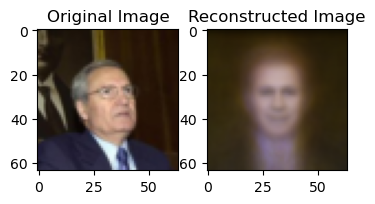

In [37]:
test(vae_model, 'Y:/user/jwkim/lfw/all_imgs\\Farouk_al-Sharaa_0002.jpg')  

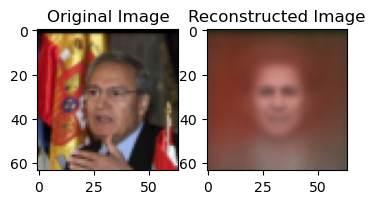

In [39]:
test(vae_model, 'Y:/user/jwkim/lfw/all_imgs\\Farouk_al-Sharaa_0003.jpg')  

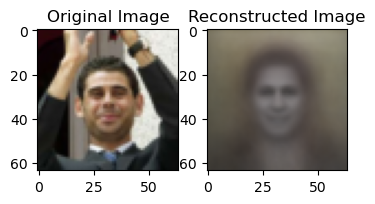

In [40]:
test(vae_model, 'Y:/user/jwkim/lfw/all_imgs\\Fernando_Hierro_0001.jpg')  

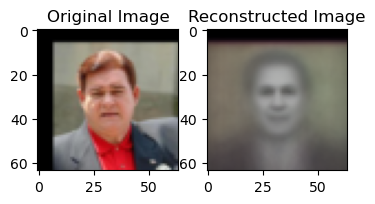

In [41]:
test(vae_model, 'Y:/user/jwkim/lfw/all_imgs\\Phil_Morris_0001.jpg')  